In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from wattsquad.ml_logic import preproc
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

In [2]:
train = pd.read_csv("../../raw_data/train.csv")

In [3]:
X_train_transformed = preproc.transform_data(train)

➡️ preprocessing done


In [4]:
test = pd.read_csv("../../raw_data/test.csv")

In [5]:
X_test_transformed = preproc.transform_data(test)

➡️ preprocessing done


### removing wind outliers

In [6]:
wind_train = train.copy()

In [7]:
wind_train.loc[wind_train["wind_production"] < -100, "wind_production"] = 21

In [8]:
y_train = wind_train['wind_production']

In [9]:
y_test = test['wind_production']

In [10]:
# test["wind_production"].describe()

In [10]:
y_train.describe()

count    9515.000000
mean       21.379504
std        37.237138
min        -1.280000
25%        -0.260000
50%         2.380000
75%        26.040000
max       225.500000
Name: wind_production, dtype: float64

### baseline MAE

In [11]:
baseline_mae = np.mean(np.abs(y_train - y_train.mean()))
print("Baseline MAE:", baseline_mae)

Baseline MAE: 25.95688035480113


### transforming target

In [12]:
from sklearn.preprocessing import PowerTransformer

# Apply Yeo-Johnson
pt = PowerTransformer(method='yeo-johnson')
y_train_transformed = pt.fit_transform(y_train.values.reshape(-1, 1))
y_test_transformed = pt.fit_transform(y_test.values.reshape(-1, 1)) ## need this??

# Reverse Transformation
# original_target = pt.inverse_transform(transformed_target)

In [14]:
# sns.histplot(data=pd.DataFrame(transformed_y_test))

In [13]:
pd.DataFrame(y_train_transformed).describe()

,0
count,9.515000e+03
mean,-7.168902e-17
std,1.000053e+00
min,-2.242263e+00
25%,-9.744332e-01
50%,-4.888293e-02
75%,9.582593e-01
max,1.738787e+00


In [14]:
pd.DataFrame(y_test_transformed).describe()

,0
count,8.410000e+02
mean,1.351805e-16
std,1.000595e+00
min,-1.542446e+00
25%,-1.124469e+00
50%,2.214476e-01
75%,8.763079e-01
max,2.068058e+00


# models

### randomized search for model

In [15]:
from sklearn.model_selection import train_test_split

# Use the same function above for the validation set
X_train_model, X_val, y_train_model, y_val = train_test_split(
    X_train_transformed, y_train_transformed, test_size = 0.1, random_state = 42  # val = 10%
)

## randomized search

In [16]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define the parameter grid
param_dist = {
    'max_depth': [5, 7, 9],                     # Maximum depth of trees
    'n_estimators': [100, 300, 500, 700],       # Number of boosting rounds
    'learning_rate': [0.01, 0.05, 0.1],         # Learning rate (shrinkage)
    'reg_alpha': [0, 0.01, 0.05, 0.1],          # L1 regularization term
    'reg_lambda': [1, 10, 20, 50],              # L2 regularization term
    'subsample': [0.7, 0.8, 0.9, 1.0],          # Fraction of samples per tree
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],   # Fraction of features per tree
    'min_child_weight': [1, 3, 5],              # Minimum sum of weights for child nodes
    'gamma': [0, 1, 5],                         # Minimum loss reduction for split
}

# Initialize the model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='mae',
    random_state=42  # Ensuring reproducibility
)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,                # Number of parameter combinations to try
    scoring='neg_mean_absolute_error',  # Metric to optimize
    cv=3,                     # 3-fold cross-validation
    verbose=2,                # Print progress
    random_state=42,          # Reproducibility
    n_jobs=-1                 # Use all available cores
)

# Perform the search
random_search.fit(X_train_model, y_train_model)

# Display the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best MAE Score:", -random_search.best_score_)

# Retrieve the best model
best_model = random_search.best_estimator_

# # Save the best model if necessary
# import joblib
# joblib.dump(best_model, 'best_xgb_model.pkl')


Fitting 3 folds for each of 50 candidates, totalling 150 fits


KeyboardInterrupt: 

In [36]:
random_search.best_params_

{'subsample': 1.0,
 'reg_lambda': 1,
 'reg_alpha': 0.1,
 'n_estimators': 700,
 'min_child_weight': 5,
 'max_depth': 9,
 'learning_rate': 0.05,
 'gamma': 0,
 'colsample_bytree': 1.0}

In [20]:
y_pred = best_model.predict(X_test_transformed)

In [21]:
baseline_mae = ((abs(y_train_transformed-y_train_transformed.mean())).mean())
baseline_mae

0.9391533702276191

In [22]:
model_mae = ((abs(y_test_transformed-y_pred)).mean())
model_mae

0.9884094305678655

In [29]:
from sklearn.metrics import mean_absolute_error

# Use sklearn's mean_absolute_error to compare
model_mae = mean_absolute_error(y_test_transformed, y_pred)
model_mae

0.9792943393495396

In [27]:
# Validation MAE
val_mae = ((abs(y_val - best_model.predict(X_val))).mean())
val_mae

1.0509120970679675

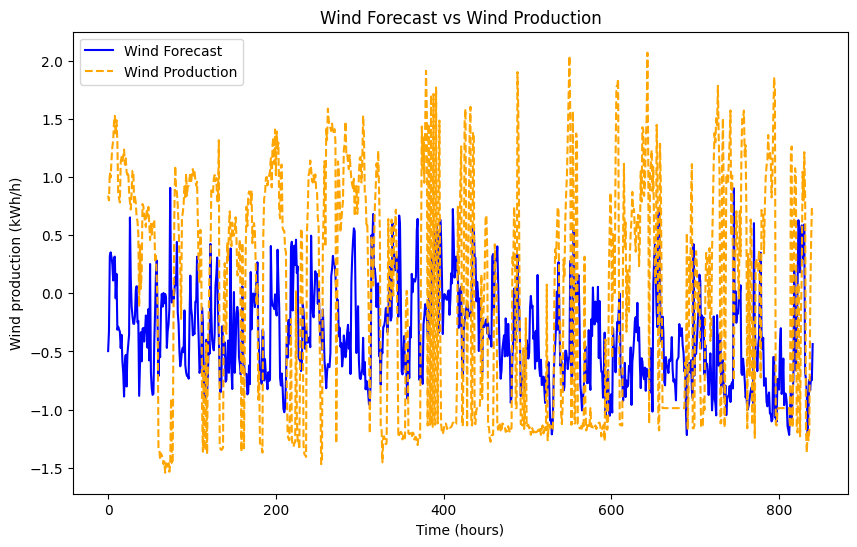

In [31]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the 'pv_forecast' column
plt.plot(y_pred, label='Wind Forecast', color='blue', linestyle='-')

# Plot the 'pv_production' column
plt.plot(y_test_transformed, label='Wind Production', color='orange', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Wind production (kWh/h)')
plt.title('Wind Forecast vs Wind Production')
plt.legend()

# Display the plot
plt.show()

In [19]:
# # Initialize the model with the best parameters from grid search
# xgb_reg = XGBRegressor(
#     'subsample'= 0.8, 
#     'reg_lambda'= 50, 
#     'reg_alpha'= 0.1, 
#     'n_estimators'= 500, 
#     'min_child_weight'= 3, 
#     'max_depth'= 7, 
#     'learning_rate'= 0.05, 
#     'gamma'= 0, 
#     'colsample_bytree'= 1.0,
#     random_state=42             # Ensuring reproducibility
# )

# # Fit the model on the training data
# xgb_reg.fit(
#     X_train_model, 
#     y_train_model,
#     eval_set=[(X_train_model, y_train_model), (X_val, y_val)],
#     early_stopping_rounds=10     # Retain early stopping
# )

# # Make predictions
# y_pred = xgb_reg.predict(X_test_transformed) # predicted wind production

In [17]:
# sns.histplot(data=pd.DataFrame(y_pred))

In [18]:
# plt.figure(figsize=(10, 6))  # Set the figure size

# # Plot the 'pv_forecast' column
# plt.plot(y_pred, label='Wind Forecast', color='blue', linestyle='-')

# # Plot the 'pv_production' column
# plt.plot(transformed_y_test, label='Wind Production', color='orange', linestyle='--')

# # Add labels, legend, and title
# plt.xlabel('Time (hours)')
# plt.ylabel('Wind production (kWh/h)')
# plt.title('Wind Forecast vs Wind Production')
# plt.legend()

# # Display the plot
# plt.show()

### Evaluating predictions of this model on test data

# modelling with only important features

In [25]:
X_train_imp = X_train_transformed[[
    "minmaxscaler__wind_speed_100m:ms", 
    "minmaxscaler__month_cosine", 
    "minmaxscaler__month_sine",
    "minmaxscaler__cos_wind_dir_50m:d",
    "minmaxscaler__sin_wind_dir_50m:d",
    "minmaxscaler__t_10m:C"
]]

In [26]:
X_test_imp = X_test_transformed[[
    "minmaxscaler__wind_speed_100m:ms", 
    "minmaxscaler__month_cosine", 
    "minmaxscaler__month_sine",
    "minmaxscaler__cos_wind_dir_50m:d",
    "minmaxscaler__sin_wind_dir_50m:d",
    "minmaxscaler__t_10m:C"
]]

In [27]:
from sklearn.model_selection import train_test_split

# Use the same function above for the validation set
X_train_model, X_val, y_train_model, y_val = train_test_split(
    X_train_imp, y_train_transformed, test_size = 0.1, random_state = 42  # val = 10%
)

### building first version of the model

In [36]:
from xgboost import XGBRegressor

xgb_reg = XGBRegressor(max_depth=10, n_estimators=100, learning_rate = 0.1)
xgb_reg.fit(X_train_model, y_train_model,
           # evaluate the loss at each iteration
            eval_set = [(X_train_model, y_train_model), (X_val, y_val)],
            # stop iterating when eval loss increases 5 times in a row
            early_stopping_rounds = 5
           )

y_pred = xgb_reg.predict(X_test_imp)

/home/emilymco/.pyenv/versions/3.10.6/envs/watt_squad/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:1.03833	validation_1-rmse:1.02445
[1]	validation_0-rmse:0.96582	validation_1-rmse:0.96296
[2]	validation_0-rmse:0.90211	validation_1-rmse:0.91003
[3]	validation_0-rmse:0.84536	validation_1-rmse:0.86452
[4]	validation_0-rmse:0.79474	validation_1-rmse:0.82632
[5]	validation_0-rmse:0.74977	validation_1-rmse:0.79362
[6]	validation_0-rmse:0.71012	validation_1-rmse:0.76568
[7]	validation_0-rmse:0.67432	validation_1-rmse:0.74201
[8]	validation_0-rmse:0.64254	validation_1-rmse:0.72140
[9]	validation_0-rmse:0.61545	validation_1-rmse:0.70525
[10]	validation_0-rmse:0.59098	validation_1-rmse:0.69362
[11]	validation_0-rmse:0.56872	validation_1-rmse:0.68196
[12]	validation_0-rmse:0.54919	validation_1-rmse:0.67341
[13]	validation_0-rmse:0.53210	validation_1-rmse:0.66513
[14]	validation_0-rmse:0.51662	validation_1-rmse:0.65768
[15]	validation_0-rmse:0.50270	validation_1-rmse:0.65238
[16]	validation_0-rmse:0.49009	validation_1-rmse:0.64878
[17]	validation_0-rmse:0.47878	validation

### Evaluating predictions of the first model on test data


In [37]:
baseline_mae = ((abs(y_train_transformed-y_train_transformed.mean())).mean())
baseline_mae

0.9391533702276191

In [38]:
model_mae = ((abs(y_test_transformed-y_pred)).mean())
model_mae

0.9917073997362166

### Finding the optimal parameters using GridSearch

In [39]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import numpy as np

# Define the parameter grid for GridSearch
param_grid = {
    "max_depth": [8,9,10],            # Reduce options
    "learning_rate": [0.04, 0.05, 0.06],
    "n_estimators": [600,700,800],
    "reg_alpha": [0.01, 0.02, 0.03],
    "reg_lambda": [5, 8, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.8]
}

# Initialize the model
xgb_reg = XGBRegressor(objective='reg:squarederror', eval_metric="mae", random_state=42)

# Perform the grid search
grid_search = GridSearchCV(
    estimator = xgb_reg,
    param_grid = param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 3,
    verbose = 1,
    n_jobs = -1
)

# Fit the grid search
grid_search.fit(X_train_imp, y_train_transformed)

# Get the best parameters and score
print('Best Parameters: ', grid_search.best_params_)
print('Best Score:', -grid_search.best_score_)

# Use the best model to predict
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_imp)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.04, 'max_depth': 8, 'n_estimators': 600, 'reg_alpha': 0.03, 'reg_lambda': 10, 'subsample': 0.8}
Best Score: 0.6613277928977933


### Evaluating predictions of the grid searched model on test data

In [40]:
baseline_mae = ((abs(y_train_transformed-y_train_transformed.mean())).mean())
baseline_mae

0.9391533702276191

In [41]:
model_mae = ((abs(y_test_transformed-y_pred)).mean())
model_mae

0.9760087185109603

In [29]:
# # Initialize the model with the best parameters from grid search
# xgb_reg = XGBRegressor(
#     max_depth=7,               
#     n_estimators=300,         
#     learning_rate=0.05,     
#     reg_alpha=0.05,        
#     reg_lambda=20,       
#     subsample=0.8,         
#     colsample_bytree=0.8,   
#     objective='reg:squarederror',
#     eval_metric="mae",
#     random_state=42             # Ensuring reproducibility
# )

# # Fit the model on the training data
# xgb_reg.fit(
#     X_train_model, 
#     y_train_model,
#     eval_set=[(X_train_model, y_train_model), (X_val, y_val)],
#     early_stopping_rounds=5     # Retain early stopping
# )

# # Make predictions
# y_pred = xgb_reg.predict(X_test_imp) # predicted wind production

[0]	validation_0-mae:0.95420	validation_1-mae:0.92240
[1]	validation_0-mae:0.92950	validation_1-mae:0.89943
[2]	validation_0-mae:0.90684	validation_1-mae:0.87923
[3]	validation_0-mae:0.88508	validation_1-mae:0.85899
[4]	validation_0-mae:0.87388	validation_1-mae:0.85097
[5]	validation_0-mae:0.86332	validation_1-mae:0.84306
[6]	validation_0-mae:0.85435	validation_1-mae:0.83606
[7]	validation_0-mae:0.83537	validation_1-mae:0.81850
[8]	validation_0-mae:0.82609	validation_1-mae:0.81129
[9]	validation_0-mae:0.80912	validation_1-mae:0.79617
[10]	validation_0-mae:0.80054	validation_1-mae:0.78928
[11]	validation_0-mae:0.78388	validation_1-mae:0.77426


/home/emilymco/.pyenv/versions/3.10.6/envs/watt_squad/lib/python3.10/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[12]	validation_0-mae:0.76755	validation_1-mae:0.75948
[13]	validation_0-mae:0.76208	validation_1-mae:0.75554
[14]	validation_0-mae:0.74808	validation_1-mae:0.74296
[15]	validation_0-mae:0.73528	validation_1-mae:0.73145
[16]	validation_0-mae:0.72246	validation_1-mae:0.71981
[17]	validation_0-mae:0.71579	validation_1-mae:0.71466
[18]	validation_0-mae:0.70414	validation_1-mae:0.70409
[19]	validation_0-mae:0.69819	validation_1-mae:0.69969
[20]	validation_0-mae:0.68757	validation_1-mae:0.69011
[21]	validation_0-mae:0.67725	validation_1-mae:0.68132
[22]	validation_0-mae:0.67259	validation_1-mae:0.67788
[23]	validation_0-mae:0.66807	validation_1-mae:0.67436
[24]	validation_0-mae:0.66362	validation_1-mae:0.67096
[25]	validation_0-mae:0.65979	validation_1-mae:0.66813
[26]	validation_0-mae:0.65005	validation_1-mae:0.65908
[27]	validation_0-mae:0.64643	validation_1-mae:0.65653
[28]	validation_0-mae:0.63817	validation_1-mae:0.64911
[29]	validation_0-mae:0.63000	validation_1-mae:0.64147
[30]	valid

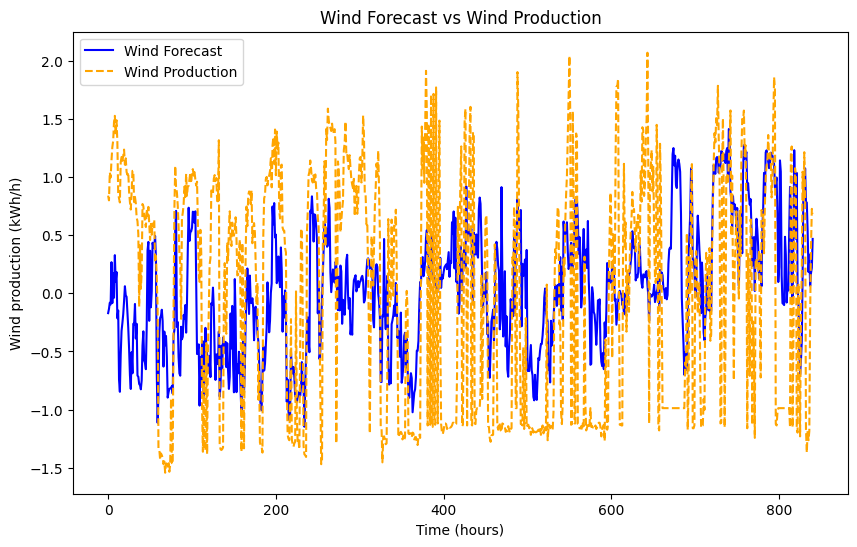

In [32]:
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot the 'pv_forecast' column
plt.plot(y_pred, label='Wind Forecast', color='blue', linestyle='-')

# Plot the 'pv_production' column
plt.plot(y_test_transformed, label='Wind Production', color='orange', linestyle='--')

# Add labels, legend, and title
plt.xlabel('Time (hours)')
plt.ylabel('Wind production (kWh/h)')
plt.title('Wind Forecast vs Wind Production')
plt.legend()

# Display the plot
plt.show()

In [34]:
baseline_mae = ((abs(y_train_model-y_train_model.mean())).mean())
baseline_mae

0.9393595258721651

In [35]:
model_mae = ((abs(y_test_transformed-y_pred)).mean())
model_mae

0.9715861843085714

# feature importance for wind


In [ ]:
importance = model.feature_importances_ # best_model???
feature_names = X_train_transformed.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df.sort_values(by='Importance', ascending=False, inplace=True)

In [ ]:
# X_train_transformed.columns

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()

In [ ]:
importance_df

In [ ]:
correlation_matrix = X_train_transformed.corr()

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()